In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece jiwer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.1 MB/s eta 0:00:00


In [2]:
%%bash
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
cp -r ICDAR-2019-SROIE/data ./
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


In [3]:
import os
import json
from pathlib import Path
import shutil
 
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
metadata_list = []
 
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    data = json.load(json_file)
    text = json.dumps(data)
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
 
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')
 
shutil.rmtree(metadata_path)

In [4]:
from datasets import load_dataset
 
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
 
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")
 
print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 496
OCR text is {"company": "SANYU STATIONERY SHOP", "date": "06/07/2017", "address": "NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM", "total": "4.50"}


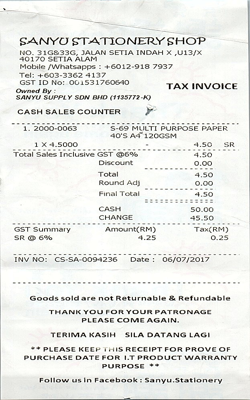

In [5]:
import random
 
random_sample = random.randint(0, len(dataset))
 
print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))

In [6]:
new_special_tokens = []
task_start_token = "<s>"
eos_token = "</s>"
 
def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"
        return obj
 
 
def preprocess_documents_for_donut(sample):
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}
 
proc_dataset = dataset.map(preprocess_documents_for_donut)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [7]:
from transformers import DonutProcessor
 
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

new_special_tokens = list(set(new_special_tokens))
new_special_tokens.sort()
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

processor.feature_extractor.size = [720,960]
processor.feature_extractor.do_align_long_axis = False

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:224: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [8]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
 
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)
 
    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.
Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.


In [9]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


In [10]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig, logging

logging.set_verbosity_error()
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
logging.set_verbosity_warning()

new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]
 
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print()

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:224: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [11]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback

class CustomSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        inputs.pop("num_items_in_batch", None)
        return super().compute_loss(model, inputs, return_outputs=return_outputs)

batch_size = 2
gradien_acc = 16

training_args = Seq2SeqTrainingArguments(
    output_dir="donut-base-sroie",
    num_train_epochs=30,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradien_acc,
    
    optim="adamw_torch_fused",
    learning_rate=1e-5,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    warmup_steps=int(0.1 * (563 / batch_size * gradien_acc)),
    
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    
    save_total_limit=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    predict_with_generate=False,
    overwrite_output_dir=True,
    report_to="none",
    
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True,
    
    dataloader_num_workers=4,
    dataloader_prefetch_factor=4,
    dataloader_pin_memory=True,
    fp16=True,
    bf16=False,
)

trainer = CustomSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [12]:
trainer.train(resume_from_checkpoint=False)

`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
0,125.068100,7.487394
1,118.519500,6.835139
2,107.750300,6.105186
3,96.558500,5.414803
4,86.572400,4.827568
5,76.993200,4.277330
6,69.527600,3.845214
7,62.728700,3.451252
8,56.900000,3.145480
9,51.765600,2.913548


There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].


TrainOutput(global_step=510, training_loss=45.81001257802926, metrics={'train_runtime': 13300.3883, 'train_samples_per_second': 1.27, 'train_steps_per_second': 0.038, 'total_flos': 2.9011095434214605e+19, 'train_loss': 45.81001257802926, 'epoch': 29.9645390070922})

In [13]:
model.save_pretrained("./trained_donut")
processor.save_pretrained("./trained_donut")

[]

In [14]:
logging.set_verbosity_error()
model = VisionEncoderDecoderModel.from_pretrained("./trained_donut").to(device)
processor = DonutProcessor.from_pretrained("./trained_donut")
logging.set_verbosity_warning()

In [15]:
import transformers

 
transformers.logging.disable_default_handler()

 
def run_prediction(sample, model=model, processor=processor):
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
 
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
 
    target = processor.token2json(sample["target_sequence"])
    return prediction, target

In [16]:
test_sample = processed_dataset["test"][random.randint(1, 50)]
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:674: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Reference:
 {'total': 'RM 21.50', 'date': '22-05-16', 'company': 'MR. D.I.Y. (M) SDN BHD', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR'}
Prediction:
 {'total': 'RM 21.50', 'date': '22-05-16', 'company': 'MR. D.I.Y. (M) SDN BHD', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR'}


In [17]:
from tqdm import tqdm

true_counter = 0
total_counter = 0
 
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1
 
print(f"Accuracy: {(true_counter/total_counter)*100}%")

100%|██████████| 63/63 [01:33<00:00,  1.48s/it]

Accuracy: 100.0%
